# Data Cleaning

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_cleaning import read_gas_data, create_feature_df

sns.set_style('darkgrid')
file_path = fr'raw/USGasData.xlsx'
tabs = ['Storage', 'Production', 'Demand-Actual', 'Demand-Normal', 'Prices-Cash', 'Prices-Cash Basis']
pickle_files = ['storage.pkl', 'production.pkl', 'demand_actual.pkl', 'demand_normal.pkl', 'prices.pkl', 'basis.pkl']
cap = 100
cap_prices = True
read_pickle = False

S, PD, DA, DN, P, B = read_gas_data(file_path, cap_prices=cap_prices, cap=cap, read_pickle=True)
F = create_feature_df(S, PD, DA, DN, actual=True)

In [2]:
F.columns

MultiIndex([(     'C',       'EC'),
            (     'C',      'Sto'),
            (     'C',       'WC'),
            (    'MC',       'LM'),
            (    'MC',       'MW'),
            (    'MC',       'Pl'),
            (    'MC',      'Sto'),
            (    'NE',        'A'),
            (    'NE',      'App'),
            (    'NE',    'NY/NJ'),
            (    'NE',     'NewE'),
            (    'NE',      'Sto'),
            (    'RM',       'RM'),
            (    'RM',      'Sto'),
            (    'SE',       'AC'),
            (    'SE',       'NL'),
            (    'SE',       'SC'),
            (    'SE',       'SL'),
            (    'SE',      'Sto'),
            (    'TX',       'NT'),
            (    'TX',       'ST'),
            (    'TX',      'Sto'),
            (    'TX',       'WT'),
            (     'W',     'Cali'),
            (     'W', 'Cali Sto'),
            (     'W',       'DS'),
            (     'W',   'DS Sto'),
            (     'W',      

## Charting

<AxesSubplot: xlabel='Date'>

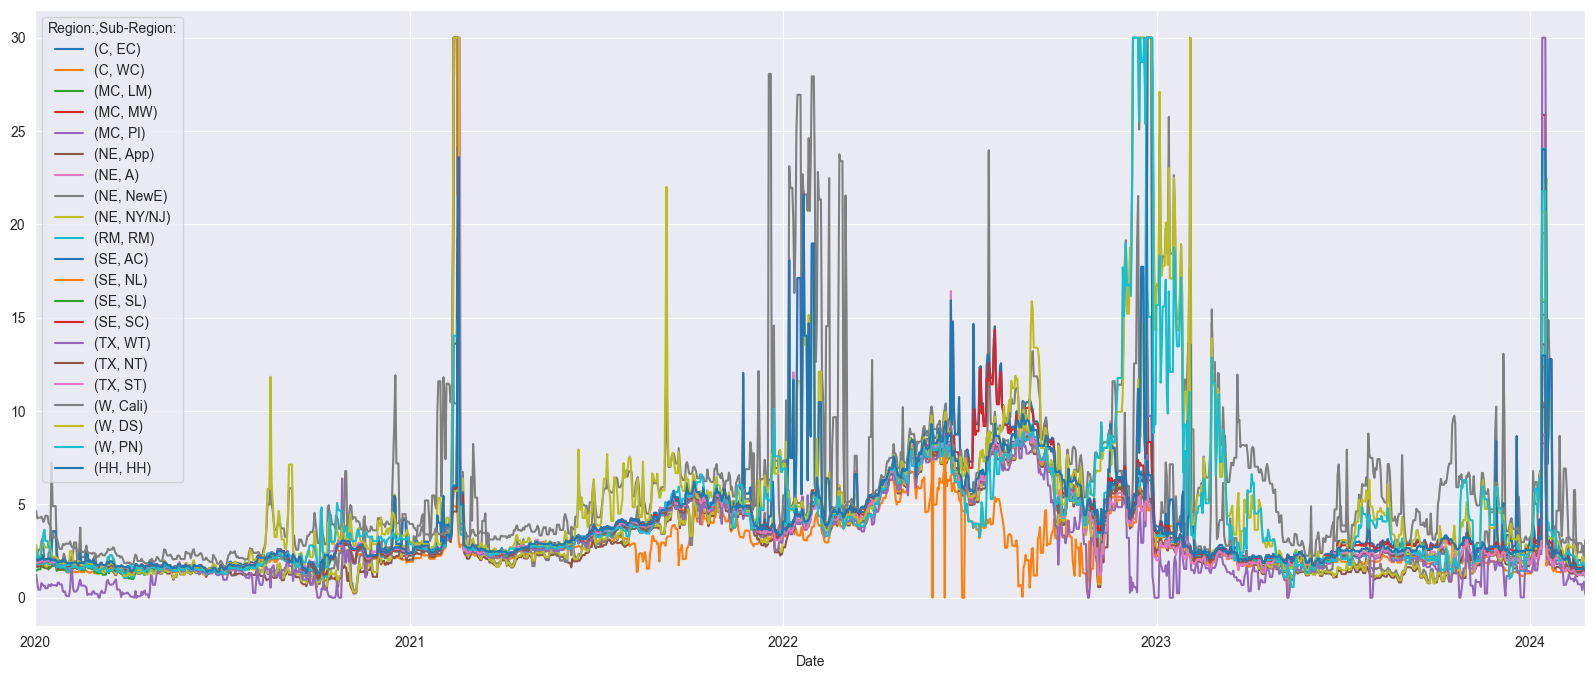

In [3]:
P.plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

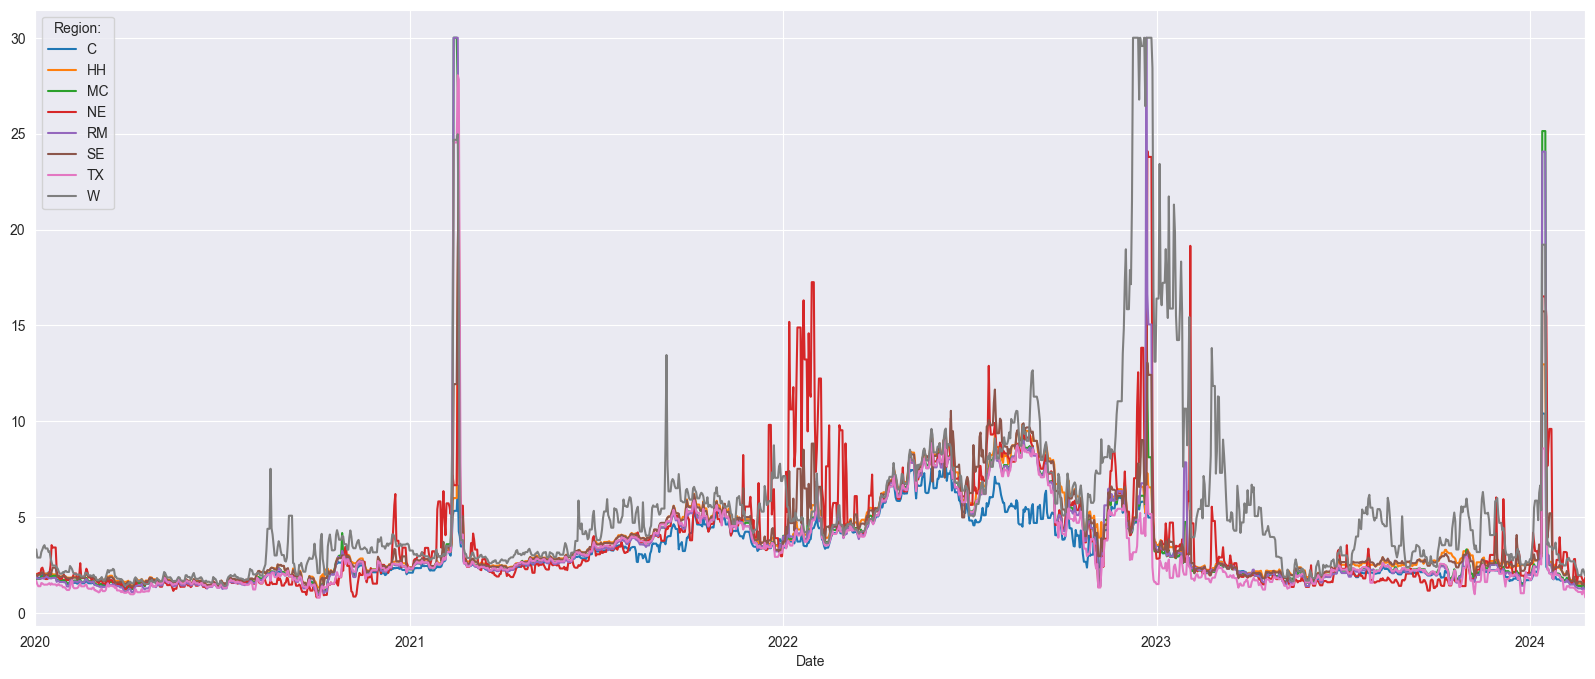

In [4]:
P.groupby(level=0,axis=1).mean().plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

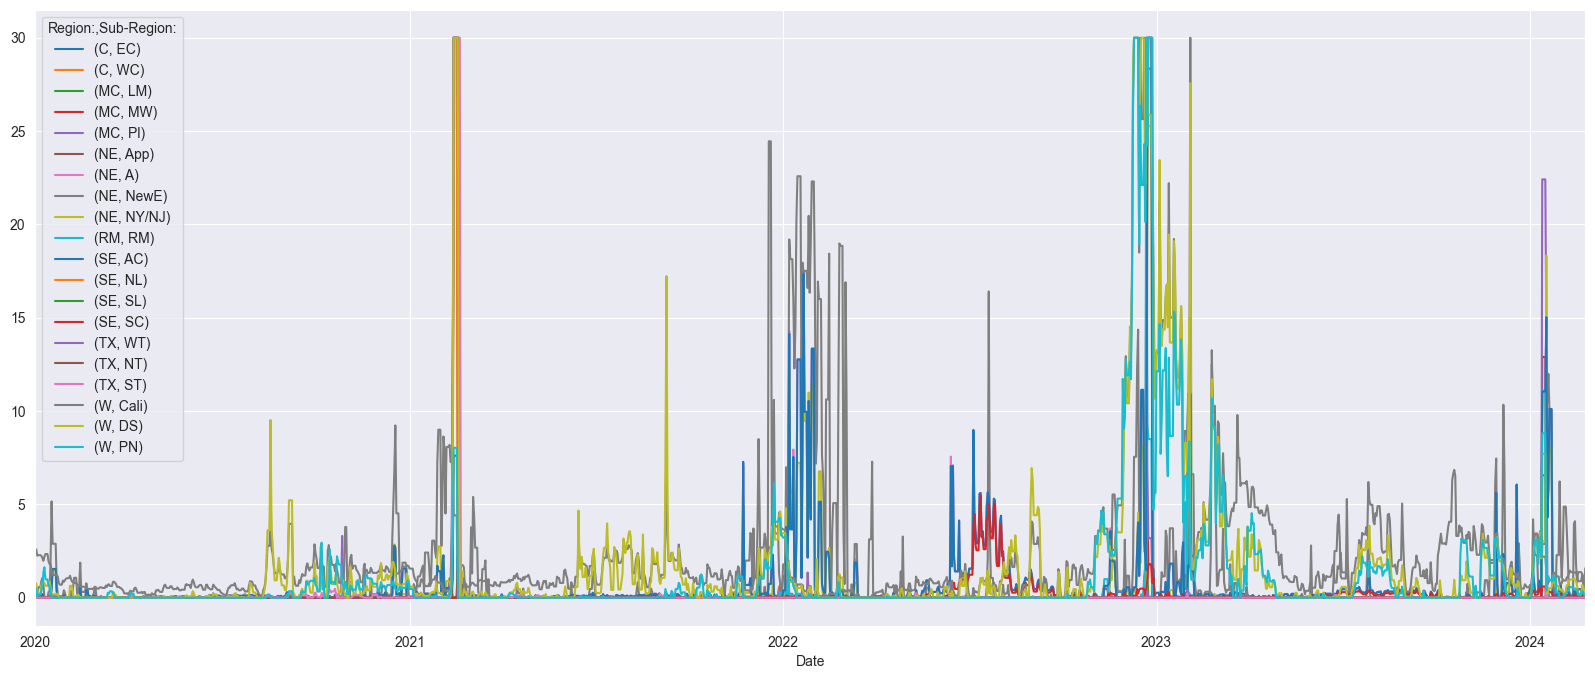

In [5]:
B.plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

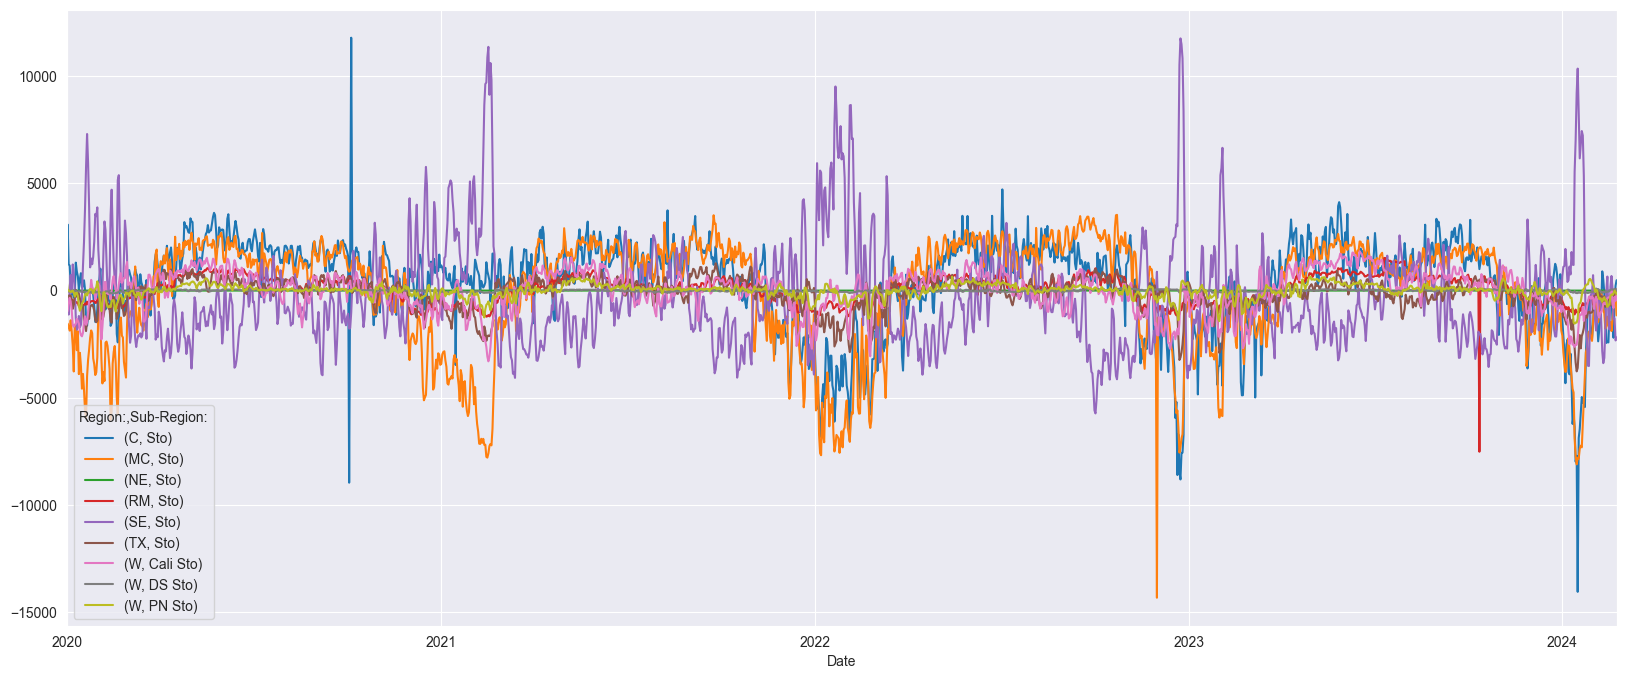

In [6]:
S.plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

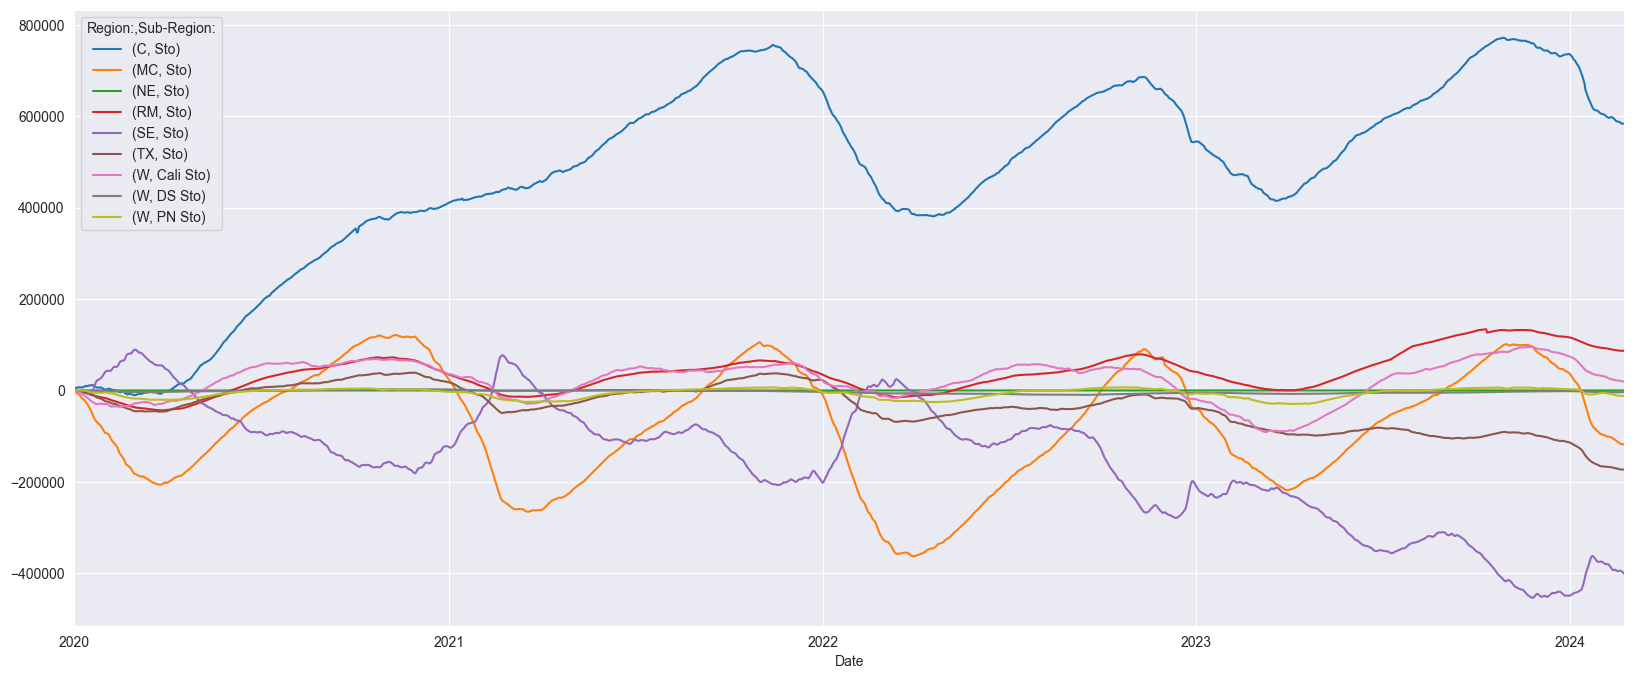

In [7]:
S.cumsum().plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

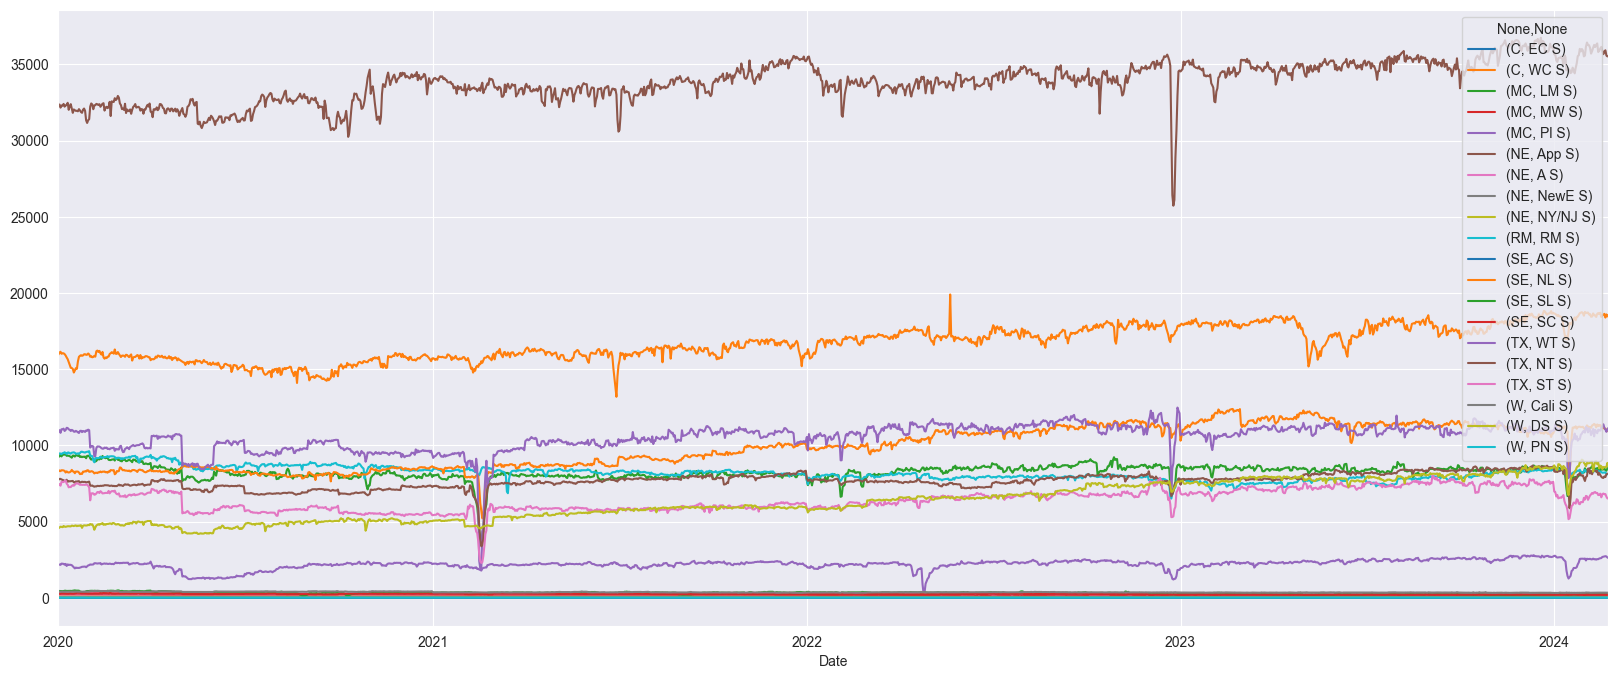

In [8]:
PD.plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

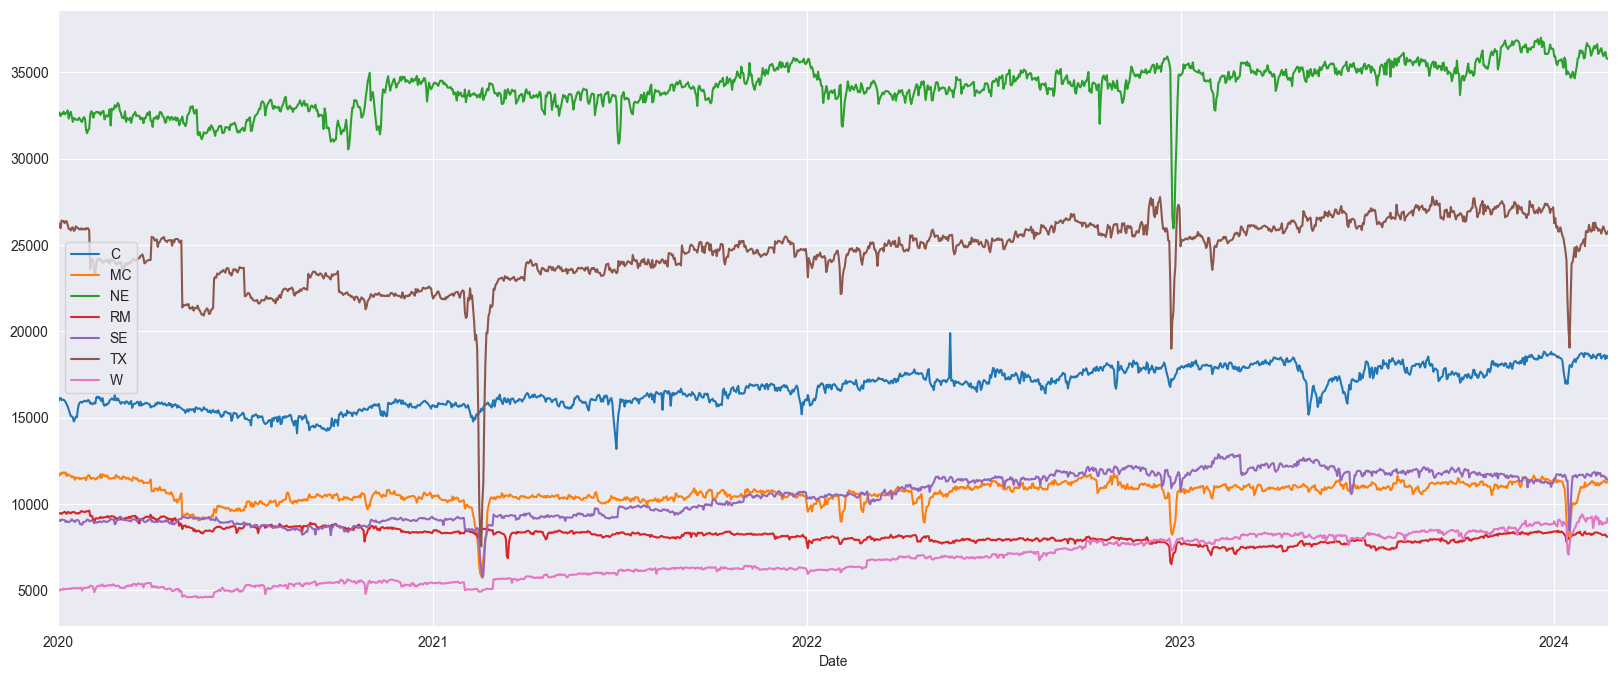

In [9]:
PD.groupby(level=0,axis=1).sum().plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

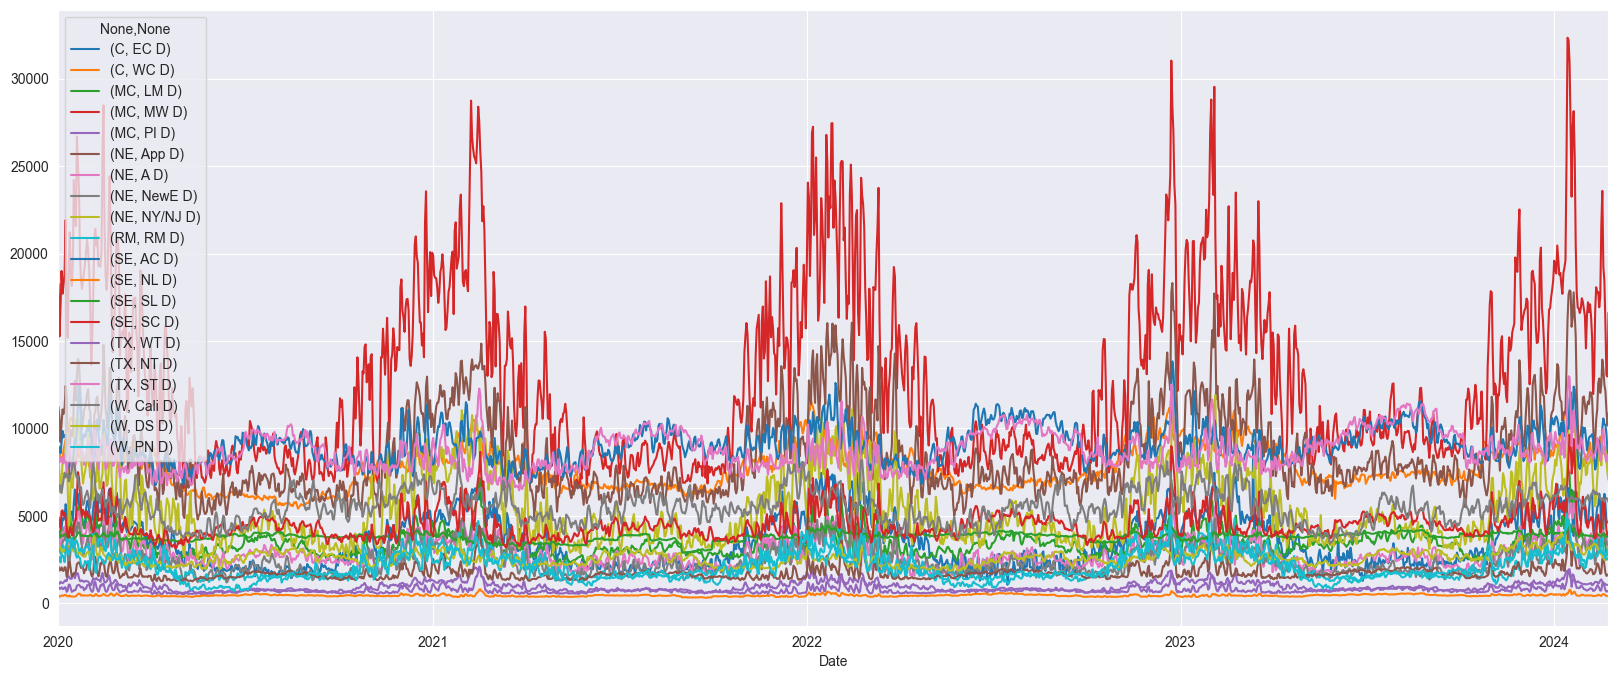

In [10]:
DA.plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

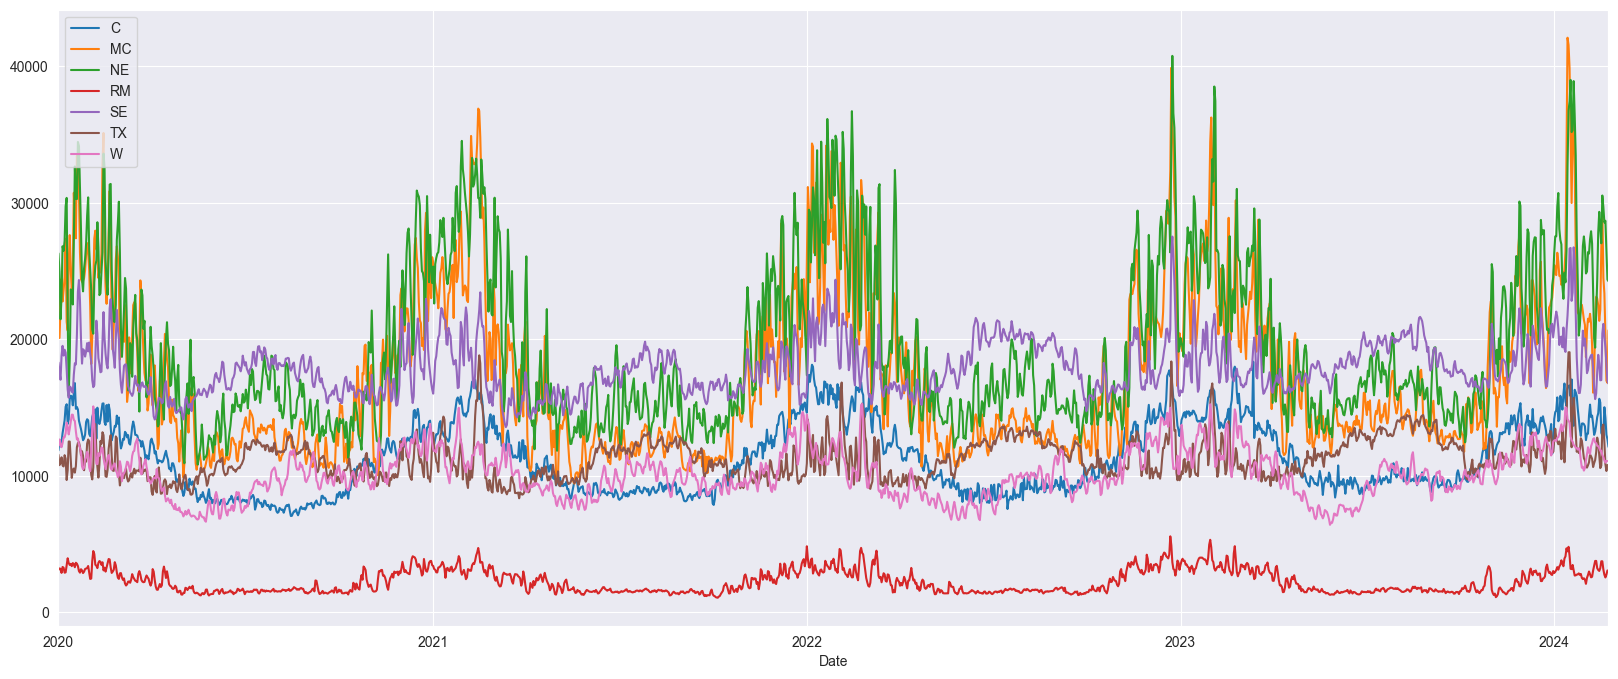

In [11]:
DA.groupby(level=0,axis=1).sum().plot(figsize=(20,8))

<AxesSubplot: xlabel='Date'>

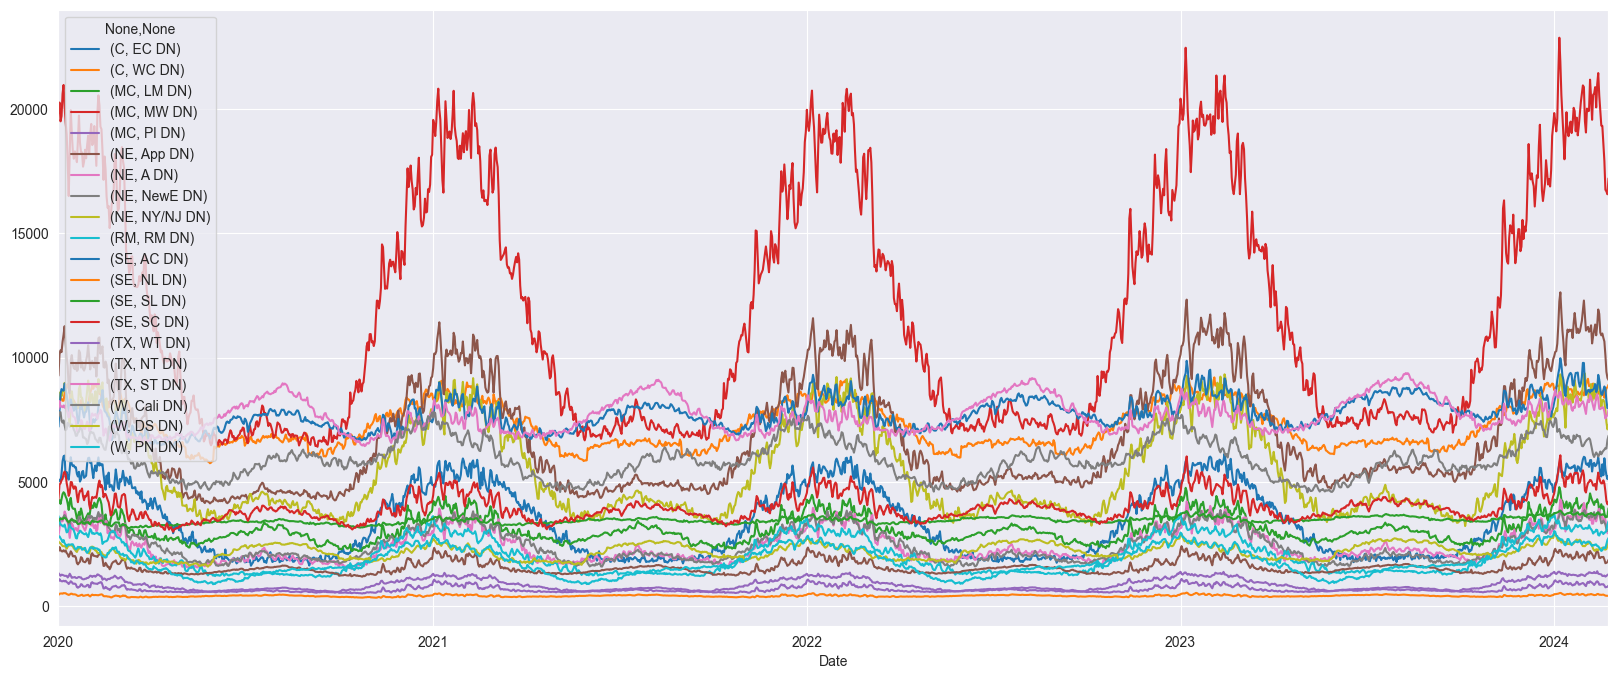

In [12]:
DN.plot(figsize=(20,8))

# Correlations

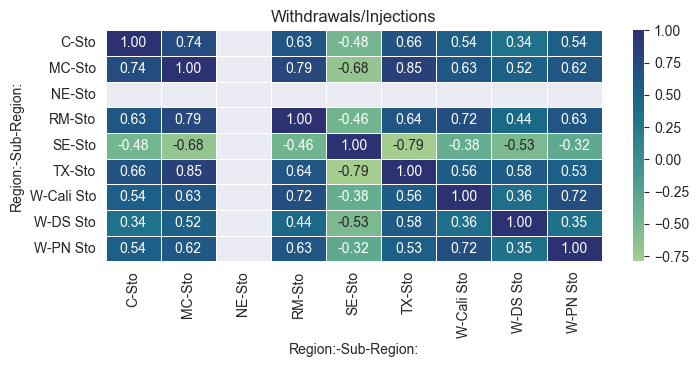

In [13]:
# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8,3))
sns.heatmap(
    S.corr().round(2), 
    annot=True, cmap='crest', fmt='.2f', linewidths=.5)

# Set the title
plt.title('Withdrawals/Injections')

# Show the plot
plt.show()



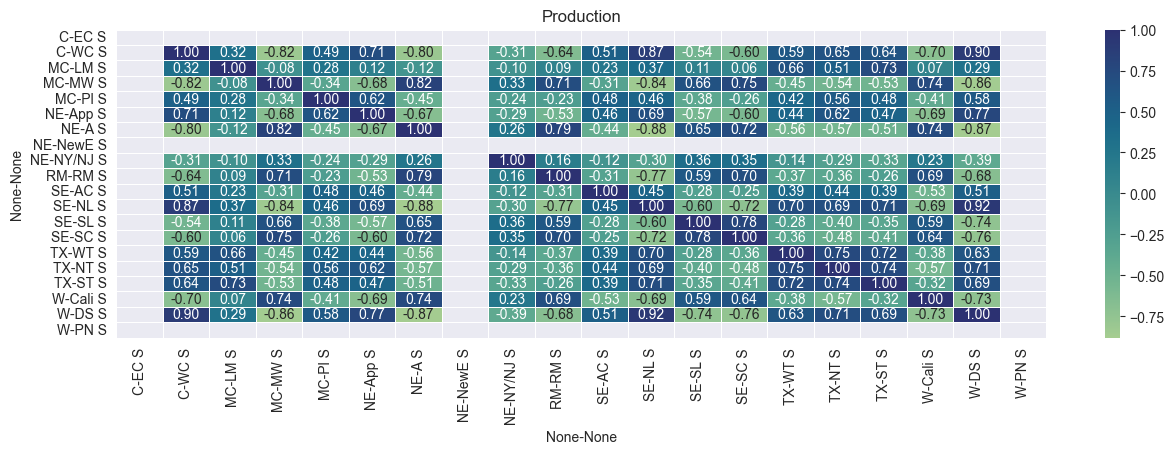

In [14]:
# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(15,4))
sns.heatmap(
    PD.corr().round(2), 
    annot=True, cmap='crest', fmt='.2f', linewidths=.5)

# Set the title
plt.title('Production')

# Show the plot
plt.show()



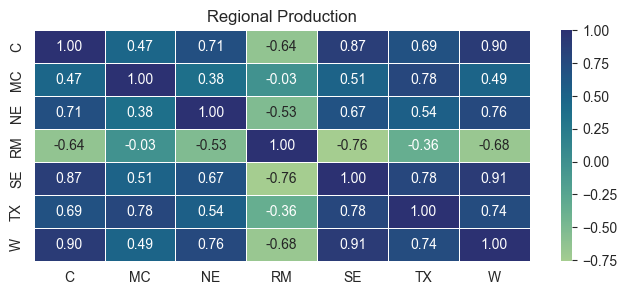

In [15]:
# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8,3))
sns.heatmap(
    PD.groupby(axis=1,level=0).sum().corr().round(2), 
    annot=True, cmap='crest', fmt='.2f', linewidths=.5)

# Set the title
plt.title('Regional Production')

# Show the plot
plt.show()




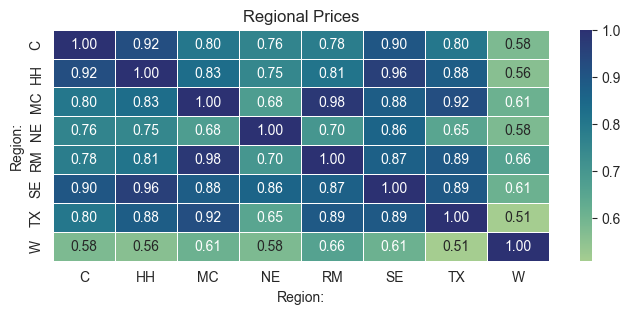

In [16]:
# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8,3))
sns.heatmap(
    P.groupby(axis=1,level=0).mean().corr().round(2), 
    annot=True, cmap='crest', fmt='.2f', linewidths=.5)

# Set the title
plt.title('Regional Prices')

# Show the plot
plt.show()


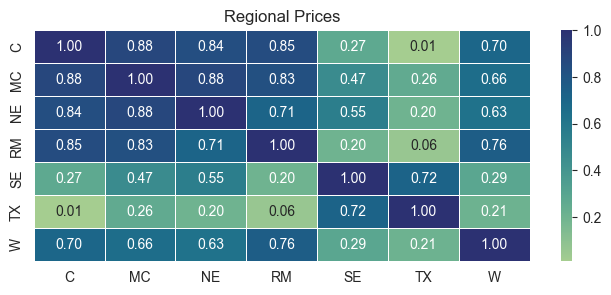

In [17]:
# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8,3))
sns.heatmap(
    DA.groupby(axis=1,level=0).sum().corr().round(2), 
    annot=True, cmap='crest', fmt='.2f', linewidths=.5)

# Set the title
plt.title('Regional Prices')

# Show the plot
plt.show()


# Modelling

## Setup

* Subregion/Selection
    * Use same data or restrict to neighbours?
* Time 
    * Rolling window
    * Expanding window
* Forecast horizon
    * Shift from 1 to 14 days in advance

## Features

* Supply
    * Include storage, cumulative storage, or not at all?
* Demand
    * Actual or normal?
* Price
    * Feed in prices, basis, etc
* Seasonality
    * How to encode? Month, season, year

## Target

* Clipping
    * How much to clip by?
* Basis vs Price
    * Predict basis vs price?
* Differential
    * Predict change in price or actual price or returns?

## Model

* Type
    * Regression vs RF vs XGB vs CatBoost
* Plan
    * Take the past 13M of data
    * Train a simple RF/XGB/CB on 12M, test out 1M.
    * Do this for an entire years worth of data

In [3]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def forecast_multi_day(max_lookahead, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> pd.DataFrame:

    # Initialize an empty DataFrame to store predictions
    predictions_df = pd.DataFrame(index=y_test.index[:-max_lookahead], columns=[f"D_{i}" for i in range(1, max_lookahead)])
    
    # Loop through each day to forecast
    for i in range(1, max_lookahead):
        # Slice X data to align with shifted y data
        X_train_shifted = X_train[:-i]
        X_test_shifted = X_test[:-i]
        y_train_shifted = y_train.shift(-i).dropna()

        # Train a RandomForestRegressor model
        params = {
        "n_estimators": 500,
        "max_depth":20,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
        "enable_categorical" : True
        }

        model = XGBRegressor(**params)
        model.fit(X_train_shifted, y_train_shifted)   
        # Make predictions for the next i days
        predictions = model.predict(X_test_shifted)

        # Store predictions in the DataFrame
        predictions_df[f"D_{i}"] = predictions[:-(max_lookahead-i)]

    # Initialize an empty DataFrame with the same shape as predictions_df
    true_df = pd.DataFrame(index=predictions_df.index, columns=predictions_df.columns)

    # Shift the values in y_test and fill y_true
    for i, col in enumerate(predictions_df.columns, start=1):
        true_df[col] = y_test.shift(-i)
    
    feature_importances = pd.Series(index=X_train.columns, data=model.feature_importances_).sort_values()
    
    return predictions_df.round(2), true_df, feature_importances



In [4]:


def produce_predictions(max_lookahead, F, P, region, subregion, train_date_start, train_date_end, test_date_start, test_date_end, DS_only, region_only):

    R = P.pct_change()
    mask = F.columns.get_level_values(1).str.endswith(("D", "S")) if DS_only else F.columns
    F_ = F.loc[:,mask]
    F_ = F[region] if region_only else F
    

    X_train = F_.loc[train_date_start:train_date_end]
    X_test = F_.loc[test_date_start, test_date_end]

    Y_train = R.loc[train_date_start:train_date_end][region][subregion]
    Y_test =  R.loc[test_date_start:test_date_end][region][subregion]

    preds, true, fi = forecast_multi_day(max_lookahead, X_train, X_test, Y_train, Y_test)
    error = true - preds
    
    return preds, true, error, fi

In [5]:
preds, true, error, fi = produce_predictions( 
                                                max_lookahead=2,
                                                F=F,
                                                P=P,
                                                region='SE',
                                                subregion='HH',
                                                train_date_start='2020',
                                                train_date_end='2022-05',
                                                test_date_start='2022-06',
                                                test_date_end='2022-06',
                                                DS_only=False,
                                                region_only=False
                                             )

C:\Users\Ryan\AppData\Local\Temp\ipykernel_55760\880578095.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = F_.loc[test_date_start, test_date_end]
c:\Users\Ryan\.conda\envs\avm\lib\site-packages\xgboost\core.py:160: UserWarning: [16:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "loss", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


<AxesSubplot: xlabel='Date'>

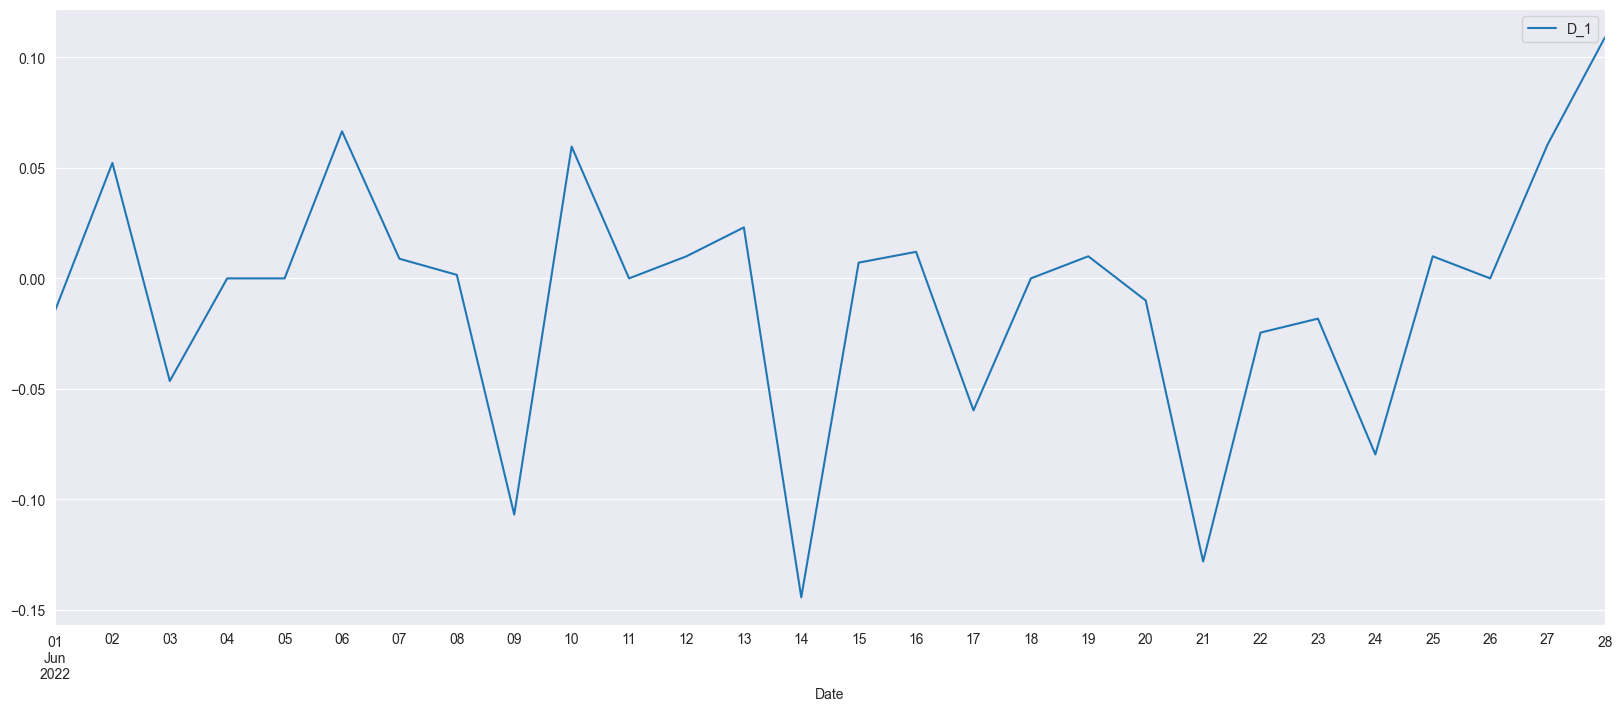

In [8]:
error.plot(figsize=(20,8))